In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
#不显示警告信息
import warnings
warnings.filterwarnings('ignore')

# 数据获取
分别对tusahre、tushare pro、akshare和baostock四个当前较流行的开源数据包构建统一参数的数据获取函数，比较程序编写的复杂程度和获取数据所需。时间

In [2]:
#使用tushare旧版获取数据
import tushare as ts
def get_from_tushare(code,adj='hfq',start='2010-01-01',end='2021-11-05'):
    df=ts.get_k_data(code,autype=adj,start=start,end=end)
    df.index=pd.to_datetime(df.date)
    #原数据已默认按日期进行了排序
    return df

#使用tushare pro获取数据
import tushare as ts
#注意：tushare pro版需要注册并获取token，某些数据有积分限制
#注册网址：https://tushare.pro/register?reg=218422
token='输入你的token'
pro=ts.pro_api(token)
ts.set_token(token)
def get_from_tushare_pro(code,adj='hfq',start='2010-01-01',end='2021-11-05'):
    #code:输入数字字符串，如‘300002’
    #start和end输入'年-月-日'需转为'年月日'格式
    if code.startswith('6'):
        code=code+'.SH'
    else:
        code=code+'.SZ'
    start=''.join(start.split('-'))
    end=''.join(end.split('-'))
    df=ts.pro_bar(ts_code=code,adj=adj,start_date=start,end_date=end)
    #原数据是倒序的，所以将时间设置为索引，根据索引重新排序
    df.index=pd.to_datetime(df.trade_date)
    df=df.sort_index()
    return df

#使用akshare获取数据,其数据源来自新浪，与tushare旧版本相似
import akshare as ak
def get_from_akshare(code,adj='hfq',start='2010-01-01',end='2021-11-05'):
    if code.startswith('6'):
        code='sh'+code
    else:
        code='sz'+code
    start=''.join(start.split('-'))
    end=''.join(end.split('-'))
    df = ak.stock_zh_a_daily(symbol=code, start_date=start, end_date=end, adjust=adj)
    return df

#使用baostock获取数据
import baostock as bs
def get_from_baostock(code,adj='hfq',start='2010-01-01',end='2021-11-05'):
    if code.startswith('6'):
        code='sh.'+code
    else:
        code='sz.'+code
    #转换复权为数字
    if adj=='hfq':
        adj='1'
    elif adj=='qfq':
        adj='2'
    else:
        adj='3'
    #必须登陆和登出系统
    bs.login() #登陆系统
    rs = bs.query_history_k_data_plus(code,
       fields="date,code,open,high,low,close,volume",
       start_date=start, end_date=end,
       frequency="d", adjustflag=adj)
    #adjustflag：复权类型，默认不复权：3；1：后复权；2：前复权
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    #将数据转为dataframe格式
    df = pd.DataFrame(data_list, columns=rs.fields)
    df.index=pd.to_datetime(df.date)
    bs.logout() #登出系统 
    return df

In [3]:
func={'tushare':get_from_tushare,
           'tushare pro':get_from_tushare_pro,
           'akshare':get_from_akshare,
           'baostock':get_from_baostock}
code='300002'
from time import time
data=pd.DataFrame()
for name,f in func.items():
    t0=time()
    data[name]=f(code).close
    t1=time()
    print(f'{name}耗时:{t1-t0:.04f}秒')

tushare耗时:1.0488秒
tushare pro耗时:0.6780秒
akshare耗时:0.7795秒
login success!
logout success!
baostock耗时:1.6439秒


In [4]:
data.tail()

,tushare,tushare pro,akshare,baostock
date,,,,
2021-11-01,90.328,90.3334,90.21,90.3322325200
2021-11-02,87.096,87.1017,86.98,87.1005853600
2021-11-03,87.866,87.8712,87.75,87.8700251600
2021-11-04,88.943,88.9484,88.82,88.9472408800
2021-11-05,91.097,91.1029,90.97,91.1016723200


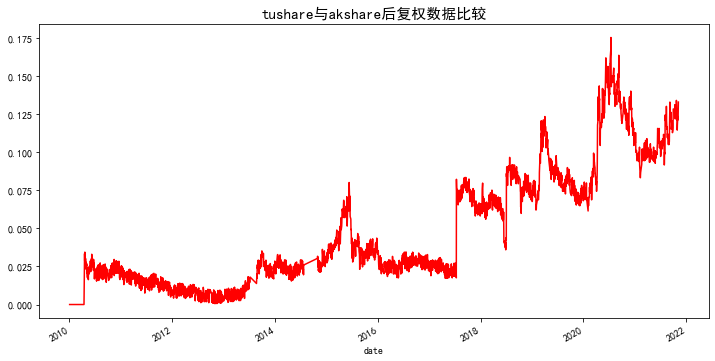

In [16]:
(data['tushare pro']-data['akshare']).plot(figsize=(12,6),c='r');
plt.title('tushare与akshare后复权数据比较',size=15);

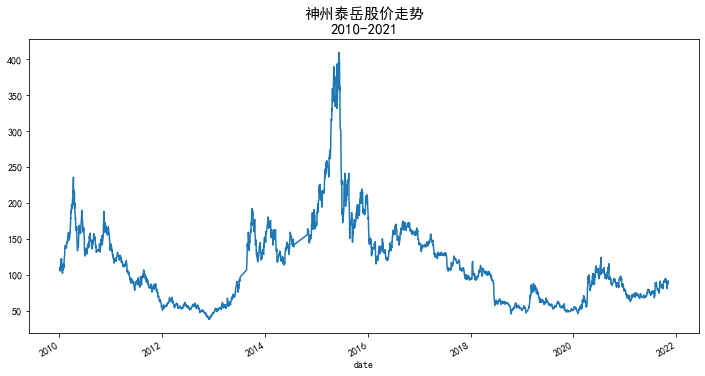

In [41]:
df=get_from_tushare('300002')
df.close.plot(figsize=(12,6));
plt.title('神州泰岳股价走势\n2010-2021',size=15);

In [18]:
(df.loc[:'2016'].close.max()-df.loc[:'2016'].close.min())/df.loc[:'2016'].close.min()

9.939483729745602

Start date,2010-01-04
End date,2021-11-05
Total months,131
,Backtest
Annual return,-1.4%
Cumulative returns,-14.5%
Annual volatility,53.8%
Sharpe ratio,0.24
Calmar ratio,-0.02
Stability,0.07
Max drawdown,-89.0%


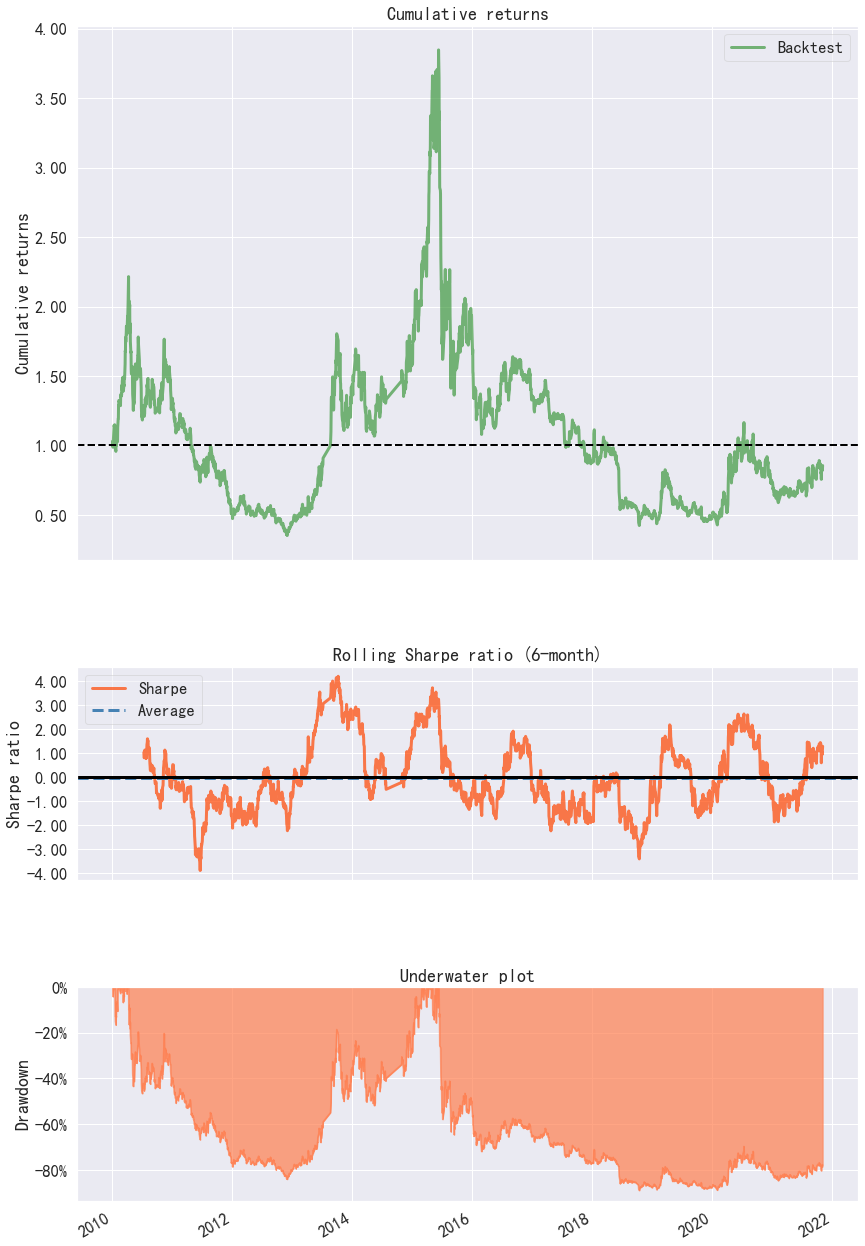

In [9]:
import pyfolio as pf
pf.create_simple_tear_sheet((df.close.pct_change()).fillna(0).tz_localize('UTC'))

In [43]:
#技术分析包
import talib as ta
def adx_strategy(df,ma1=13,ma2=55,ma3=89,adx=25):
    #计算MACD和ADX指标
    df['EMA1'] = ta.EMA(df.close,ma1)
    df['EMA2'] = ta.EMA(df.close,ma2)
    df['EMA3'] = ta.EMA(df.close,ma3)
    df['MACD'],df['MACDSignal'],df['MACDHist'] = ta.MACD(df.close,12,26,9)
    df['ADX'] = ta.ADX(df.high,df.low,df.close,14)
    #设计买卖信号:13日均线大于55日均线且55日均线大于89日均线;ADX大于前值小于30；MACD大于前值
    df['Buy_Sig'] =(df['EMA1']>df['EMA2'])&(df['EMA2']>df['EMA3'])&(df['ADX']<=30)\
                    &(df['ADX']>df['ADX'].shift(1))&(df['MACDHist']>df['MACDHist'].shift(1))
    df.loc[df.Buy_Sig,'Buy_Trade'] = 1
    df.loc[df.Buy_Trade.shift(1)==1,'Buy_Trade'] = " "
    #避免最后三天内出现交易
    df.Buy_Trade.iloc[-3:]  = " " 
    df.loc[df.Buy_Trade==1,'Buy_Price'] = df.close
    df.Buy_Price = df.Buy_Price.ffill()
    df['Buy_Daily_Return']= (df.close - df.Buy_Price)/df.Buy_Price
    df.loc[df.Buy_Trade.shift(3)==1,'Sell_Trade'] = -1
    df.loc[df.Sell_Trade==-1,'Buy_Total_Return'] = df.Buy_Daily_Return
    df.loc[(df.Sell_Trade==-1)&(df.Buy_Daily_Return==0),'Buy_Total_Return'] = \
                                (df.Buy_Price - df.Buy_Price.shift(1))/df.Buy_Price.shift(1)
    df.loc[(df.Sell_Trade==-1)&(df.Buy_Trade.shift(1)==1),'Buy_Total_Return'] = \
                                (df.close-df.Buy_Price.shift(2))/df.Buy_Price.shift(2)
    #返回策略的日收益率
    return df.Buy_Total_Return.fillna(0)

Start date,2010-01-04
End date,2021-11-05
Total months,131
,Backtest
Annual return,11.3%
Cumulative returns,221.5%
Annual volatility,19.6%
Sharpe ratio,0.63
Calmar ratio,0.46
Stability,0.81
Max drawdown,-24.2%


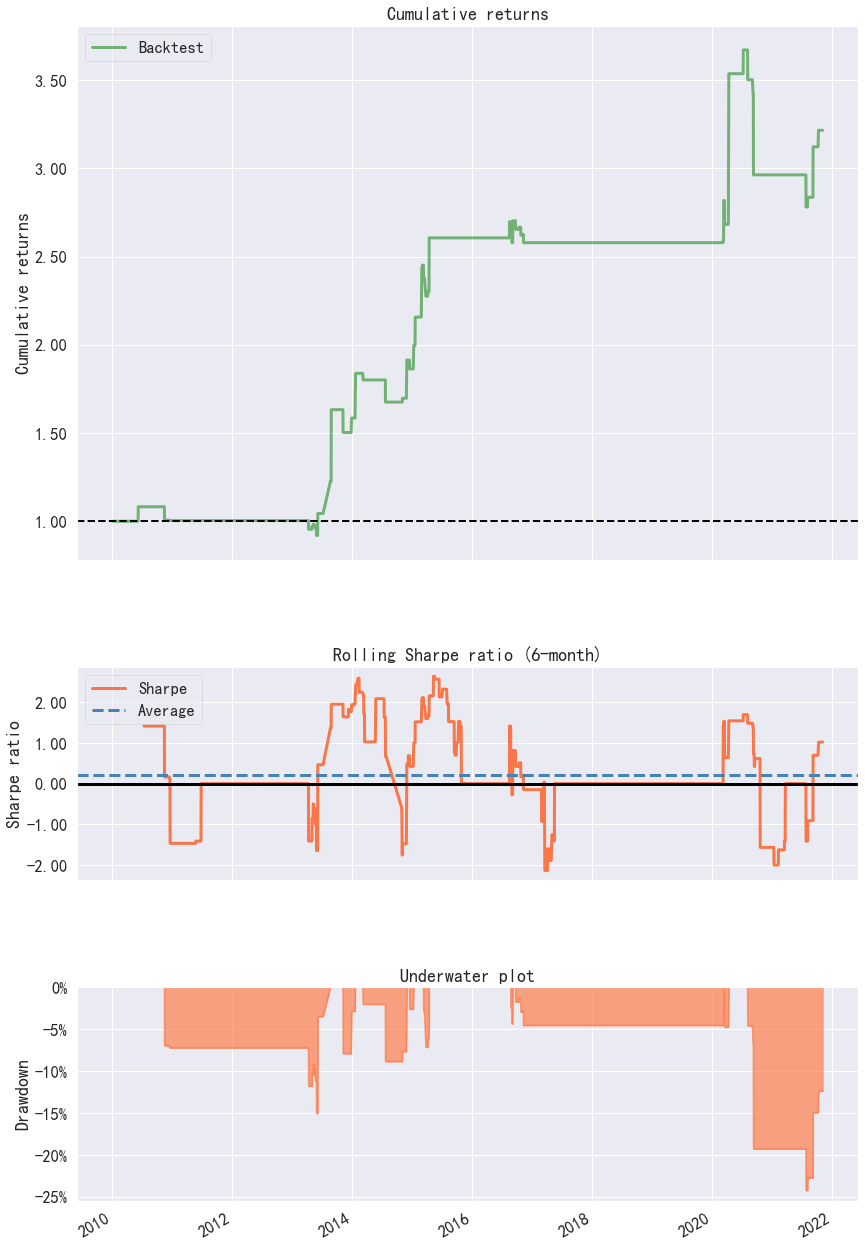

In [44]:
import pyfolio as pf
pf.create_simple_tear_sheet(adx_strategy(df).tz_localize('UTC'))